### Figure 1: Showing the start up time of vLLM for different versions using OPT-6.7B model

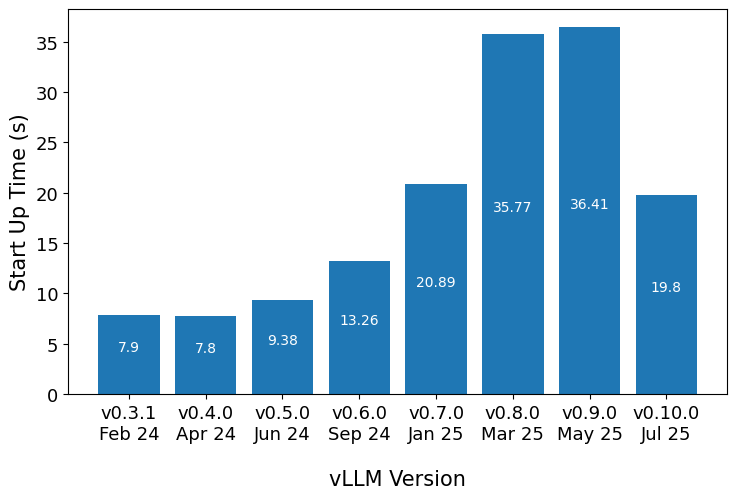

In [42]:
import matplotlib.pyplot as plt
import json

with open("examples/versions/avg_comparison_results.json", "r") as f:
    data = json.load(f)
    
labels = [label.split("_")[-1].split(".txt")[0] for label in data["labels"]]
values = [round(value, 2) for value in data["data"]["actual_total_time"]]
release_dates = ["Feb 24", "Apr 24", "Jun 24", "Sep 24", "Jan 25", "Mar 25", "May 25", "Jul 25"]

plt.figure(figsize=(8.5, 5))
bars = plt.bar([f"{l}\n{release_dates[i]}\n" for i,l in enumerate(labels)], values)
plt.ylabel("Start Up Time (s)", fontsize=15)
plt.xlabel("vLLM Version", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{value}', ha='center', va='bottom', fontsize=10, color="white")

plt.savefig(
    "figures/vllm-version-startuptime.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

In [43]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from utils import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from collections import defaultdict
import numpy as np
import matplotlib.cm as cm

def draw_no_variance(model_names_map, json_filepath, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename, func=None):
    metrics, sorted_labels, sort_indices = get_labels_matrics(json_filepath, sort_by)
    metric_values = [metrics[metric1][sort_indices[i]] for i in range(len(sorted_labels))]
    model_names = [extract_model_name(label) for label in sorted_labels]
    if func:
        model_metric_nb = [func(label) for label in sorted_labels]
    else:
        model_metric_nb = [get_model_info(label, metric2) for label in sorted_labels]

    # Now sort the values and model names based on the number of metric
    sorted_indices = sorted(range(len(model_metric_nb)), key=lambda i: model_metric_nb[i])
    metric_values_sorted = [metric_values[i] for i in sorted_indices]
    model_names_sorted = [model_names[i] for i in sorted_indices]
    model_metric_nb_sorted = [model_metric_nb[i] for i in sorted_indices]

    labels = []
    matric2_values = []
    values = []
    for i, model_name in enumerate(model_names_sorted):
        if model_name in model_names_map:
            matric2_values.append(model_metric_nb_sorted[i])
            labels.append(model_names_map[model_name])
            values.append(metric_values_sorted[i])

    cmap = cm.get_cmap("tab10", len(labels)) # "nipy_spectral", "Paired", "tab10", "turbo_r", "Spectral_r", "nipy_spectral_r"
    colors = [cmap(i) for i in range(len(labels))]

    # Main bar chart
    fig, ax = plt.subplots(figsize=(8, 5.5))
    bars = ax.bar(
        [f"{label} ({matric2_values[i]})" for i, label in enumerate(labels)],
        values,
        color=colors
    )
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_xticks(range(len(labels)))
    
    xtick_labels = []
    rotation = 30
    if metric2 != "size":
        xtick_labels = [f"{label} ({matric2_values[i]})" for i, label in enumerate(labels)]
    else:
        xtick_labels = labels
    
    if func:
        xtick_labels = matric2_values
        rotation = 0
    
    ax.set_xticklabels(xtick_labels, rotation=rotation, ha='right', fontsize=13)
    ax.set_ylim(0, max(values) * ylim_multiplier)

    # Add value of each bar on top
    for bar, value in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{value:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )
        
    # --- Create inset axes for the linear relationship ---
    # width and height are relative to the main axes (0 to 1)
    ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper left', bbox_to_anchor=(0.1, -0.04, 1, 1), bbox_transform=ax.transAxes)  

    # Linear regression
    X = np.array(matric2_values).reshape(-1, 1)
    y = np.array(values)
    reg = LinearRegression()
    reg.fit(X, y)
    y_pred = reg.predict(X)

    # Scatter + linear fit in inset
    # Scatter with matching colors
    for i in range(len(matric2_values)):
        ax_inset.scatter(matric2_values[i], values[i], color=colors[i], s=15)
    ax_inset.plot(matric2_values, y_pred, color='black', linestyle='--', linewidth=1)

    # Optional: annotate points in inset
    # point_counts = defaultdict(int)
    # def find_close_key(x, y, keys, tol_x=0.05, tol_y=0.01):
    #     for kx, ky in keys:
    #         if abs(kx - x) <= tol_x and abs(ky - y) <= tol_y:
    #             return (kx, ky)
    #     return (x, y)

    # for i, txt in enumerate(labels):
    #     x, y_val = matric2_values[i], values[i]
    #     close_key = find_close_key(x, y_val, point_counts.keys())
    #     count = point_counts[close_key]
    #     offset_y = 10 + count * 12
    #     ax_inset.annotate(
    #         txt,
    #         (x, y_val),
    #         textcoords="offset points",
    #         xytext=(0, offset_y),
    #         ha='center',
    #         fontsize=6,
    #         arrowprops=dict(arrowstyle='-', lw=0.5, color='gray')
    #     )
    #     point_counts[close_key] += 1

    ax_inset.set_xlabel(x2label, fontsize=9.5)
    ax_inset.set_ylabel(y2label, fontsize=9.5)
    ax_inset.tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()
    plt.savefig(
        f"figures/{filename}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )
    plt.show()

### Util

In [44]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from utils import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from collections import defaultdict
import numpy as np
import matplotlib.cm as cm

def draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename, func=None):
    all_values = []
    labels = []
    matric2_values = []

    for i, iter_dir in enumerate(os.listdir(iterations_path)):
        json_filepath = os.path.join(iterations_path, iter_dir, "comparison_results.json")

        metrics, sorted_labels, sort_indices = get_labels_matrics(json_filepath, sort_by)
        metric_values = [metrics[metric1][sort_indices[i]] for i in range(len(sorted_labels))]
        model_names = [extract_model_name(label) for label in sorted_labels]
        if func:
            model_metric_nb = [func(label) for label in sorted_labels]
        else:
            model_metric_nb = [get_model_info(label, metric2) for label in sorted_labels]

        # Now sort the values and model names based on the number of metric
        sorted_indices = sorted(range(len(model_metric_nb)), key=lambda i: model_metric_nb[i])
        metric_values_sorted = [metric_values[i] for i in sorted_indices]
        model_names_sorted = [model_names[i] for i in sorted_indices]
        model_metric_nb_sorted = [model_metric_nb[i] for i in sorted_indices]

        
        values = []
        for j, model_name in enumerate(model_names_sorted):
            if model_name in model_names_map:
                values.append(metric_values_sorted[j])
                if i == 0:
                    matric2_values.append(model_metric_nb_sorted[j])
                    labels.append(model_names_map[model_name])
                
        all_values.append(values)

    import scipy.stats as stats

    # Compute mean and standard error for each bar
    all_values_np = np.array(all_values)  # shape: (num_runs, num_models)
    means = np.mean(all_values_np, axis=0)
    stderrs = stats.sem(all_values_np, axis=0)

    cmap = cm.get_cmap("tab10", len(labels))
    colors = [cmap(i) for i in range(len(labels))]

    # Main bar chart with error bars
    fig, ax = plt.subplots(figsize=(8, 5.5))
    bars = ax.bar(
        [f"{label} ({matric2_values[i]})" for i, label in enumerate(labels)],
        means,
        yerr=stderrs,
        capsize=10,
        color=colors,
        ecolor='black'
    )
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_xticks(range(len(labels)))
    
    xtick_labels = []
    rotation = 30
    if metric2 != "size":
        xtick_labels = [f"{label} ({matric2_values[i]})" for i, label in enumerate(labels)]
    else:
        xtick_labels = labels
    
    if func:
        xtick_labels = matric2_values
        rotation = 0
    
    ax.set_xticklabels(xtick_labels, rotation=rotation, ha='right', fontsize=13)
    ax.set_ylim(0, max(means + stderrs) * ylim_multiplier)

    # Add value of each bar on top
    for bar, value in zip(bars, means):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2,
            f"{value:.2f}",
            ha='center',
            va='bottom',
            fontsize=10,
            color='white',
        )
        
    # --- Create inset axes for the linear relationship ---
    # width and height are relative to the main axes (0 to 1)
    ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper left', bbox_to_anchor=(0.1, -0.04, 1, 1), bbox_transform=ax.transAxes)  

    # Linear regression
    X = np.array(matric2_values).reshape(-1, 1)
    y = means
    reg = LinearRegression()
    reg.fit(X, y)
    y_pred = reg.predict(X)

    # Scatter + linear fit in inset
    # Scatter with matching colors
    for i in range(len(matric2_values)):
        ax_inset.scatter(matric2_values[i], means[i], color=colors[i], s=15)
    ax_inset.plot(matric2_values, y_pred, color='black', linestyle='--', linewidth=1)

    # Optional: annotate points in inset
    # point_counts = defaultdict(int)
    # def find_close_key(x, y, keys, tol_x=0.05, tol_y=0.01):
    #     for kx, ky in keys:
    #         if abs(kx - x) <= tol_x and abs(ky - y) <= tol_y:
    #             return (kx, ky)
    #     return (x, y)

    # for i, txt in enumerate(labels):
    #     x, y_val = matric2_values[i], means[i]
    #     close_key = find_close_key(x, y_val, point_counts.keys())
    #     count = point_counts[close_key]
    #     offset_y = 10 + count * 12
    #     ax_inset.annotate(
    #         txt,
    #         (x, y_val),
    #         textcoords="offset points",
    #         xytext=(0, offset_y),
    #         ha='center',
    #         fontsize=6,
    #         arrowprops=dict(arrowstyle='-', lw=0.5, color='gray')
    #     )
    #     point_counts[close_key] += 1

    ax_inset.set_xlabel(x2label, fontsize=9.5)
    ax_inset.set_ylabel(y2label, fontsize=9.5)
    ax_inset.tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()
    plt.savefig(
        f"figures/{filename}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )
    plt.show()

### Figure 3: Showing the relationship between tokenizer initialization and size

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


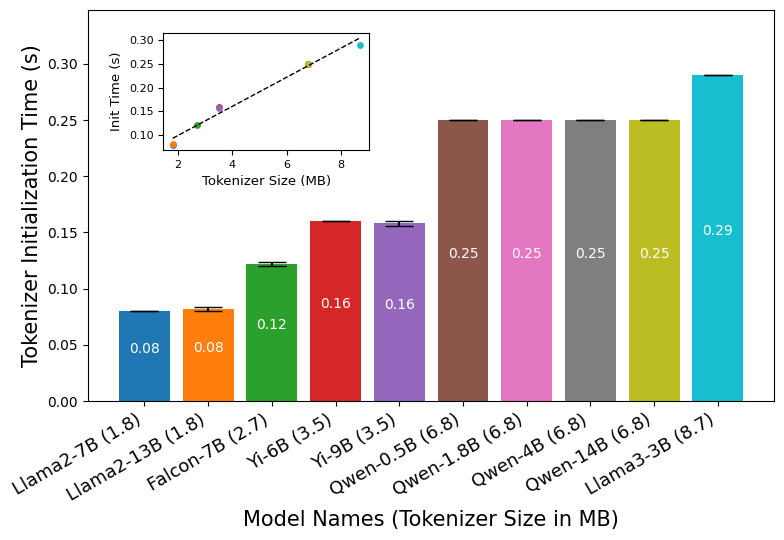

In [45]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "falcon-7b": "Falcon-7B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-0.5b": "Qwen-0.5B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "llama3-3b": "Llama3-3B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "tokenizer_init"
metric2 = "tokenizer_size"
xlabel = "Model Names (Tokenizer Size in MB)"
ylabel = "Tokenizer Initialization Time (s)"
x2label = "Tokenizer Size (MB)"
y2label = "Init Time (s)"
ylim_multiplier = 1.2
filename = "init-tokenizer-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 4: Showing the relationship between loading weights and model size

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


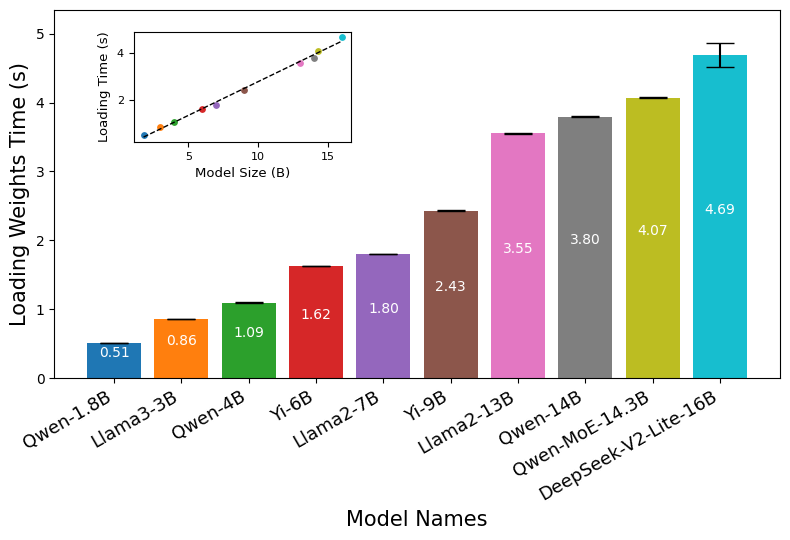

In [46]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "load_weights"
metric2 = "size"
xlabel = "Model Names"
ylabel = "Loading Weights Time (s)"
x2label = "Model Size (B)"
y2label = "Loading Time (s)"
ylim_multiplier = 1.1
filename = "load-weights-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 5: Showing the relationship between dynamo bytcode transform and number of layers

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


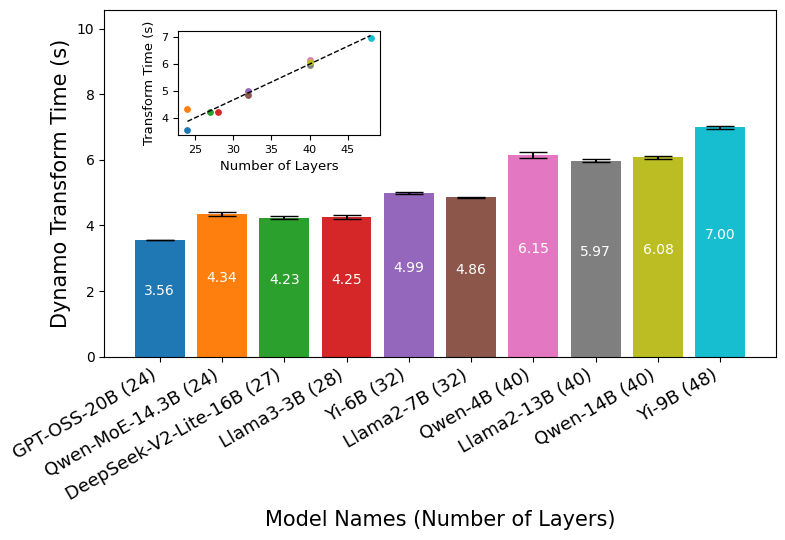

In [47]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B",
    "gpt-oss-20b": "GPT-OSS-20B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "dynamo_transform_time"
metric2 = "layers"
xlabel = "Model Names (Number of Layers)"
ylabel = "Dynamo Transform Time (s)"
x2label = "Number of Layers"
y2label = "Transform Time (s)"
ylim_multiplier = 1.5
filename = "dynamo-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 6: Showing the relationship between loading compile graph and number of layers

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


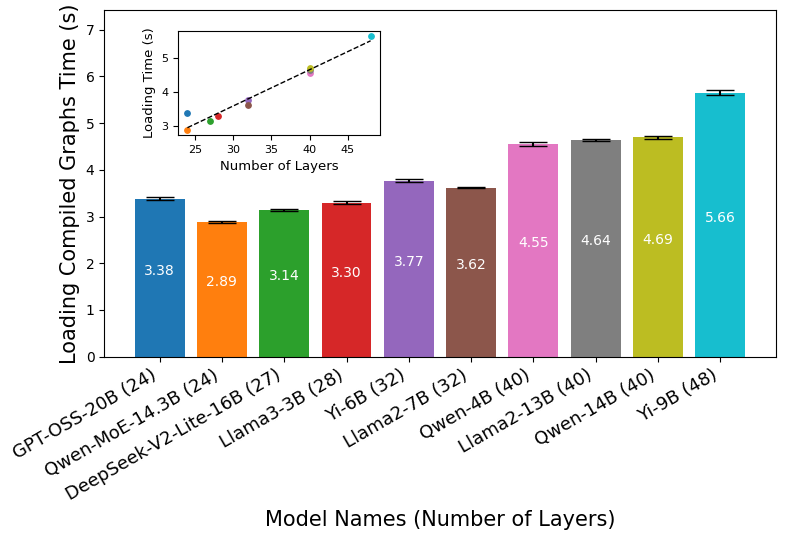

In [48]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B",
    "gpt-oss-20b": "GPT-OSS-20B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "graph_compile_cached"
metric2 = "layers"
xlabel = "Model Names (Number of Layers)"
ylabel = "Loading Compiled Graphs Time (s)"
x2label = "Number of Layers"
y2label = "Loading Time (s)"
ylim_multiplier = 1.3
filename = "load-graphs-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 7: Showing the relationship between KV cache profiling and model size

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


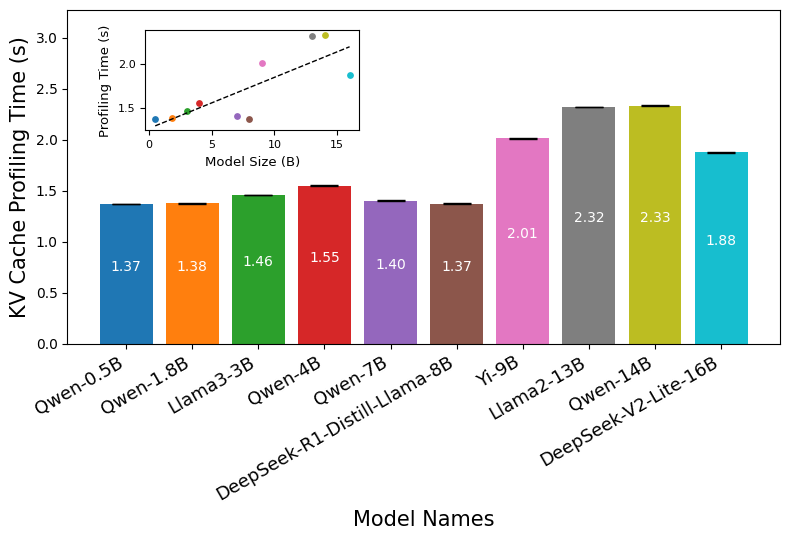

In [49]:
model_names_map = {
    "llama2-13b-hf": "Llama2-13B",
    "yi-9b": "Yi-9B",
    "qwen-0.5b": "Qwen-0.5B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-7b": "Qwen-7B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "llama3-3b": "Llama3-3B",
    "deepseek-r1-distill-llama-8b": "DeepSeek-R1-Distill-Llama-8B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "kv_cache_profiling"
metric2 = "size"
xlabel = "Model Names"
ylabel = "KV Cache Profiling Time (s)"
x2label = "Model Size (B)"
y2label = "Profiling Time (s)"
ylim_multiplier = 1.4
filename = "kv-cache-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 8: Showing the relationship between graph capturing and model size

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


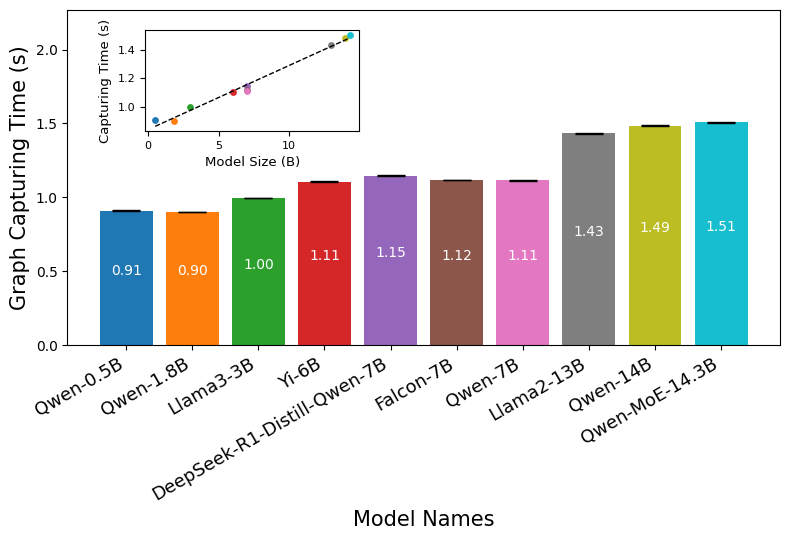

In [50]:
model_names_map = {
    "llama2-13b-hf": "Llama2-13B",
    "falcon-7b": "Falcon-7B",
    "yi-6b": "Yi-6B",
    "qwen-0.5b": "Qwen-0.5B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-7b": "Qwen-7B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-r1-distill-qwen-7b": "DeepSeek-R1-Distill-Qwen-7B",
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "graph_capturing"
metric2 = "size"
xlabel = "Model Names"
ylabel = "Graph Capturing Time (s)"
x2label = "Model Size (B)"
y2label = "Capturing Time (s)"
ylim_multiplier = 1.5
filename = "cuda-graph-model-size"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 9: Showing the relationship between graph capturing and number of batch sizes

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


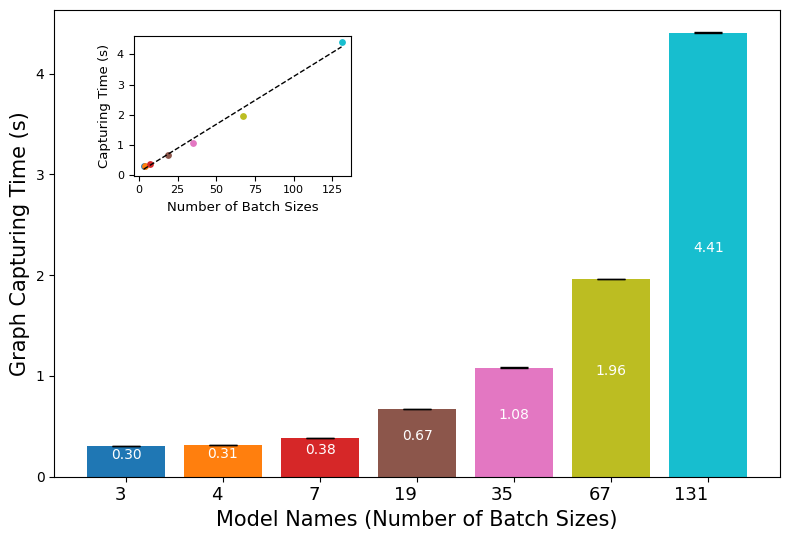

In [51]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
}
iterations_path = "examples/batch_size/iterations"
sort_by = "model_size"
metric1 = "graph_capturing"
metric2 = "size"
xlabel = "Model Names (Number of Batch Sizes)"
ylabel = "Graph Capturing Time (s)"
x2label = "Number of Batch Sizes"
y2label = "Capturing Time (s)"
ylim_multiplier = 1.05
filename = "cuda-graph-batch-size"
func = extract_batch_size
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename, func)

### Figure 11: Validation of the predictor 



train
falcon-7b | Predicted: 13.581s | Truth: 12.926 | Diff: 0.66
llama2-13b-hf | Predicted: 17.012s | Truth: 18.13 | Diff: 1.12
llama2-7b-hf | Predicted: 13.561s | Truth: 12.944 | Diff: 0.62
llama3-3b | Predicted: 11.750s | Truth: 11.28 | Diff: 0.47
qwen-0.5b | Predicted: 10.103s | Truth: 9.102 | Diff: 1.00
qwen-1.8b | Predicted: 10.420s | Truth: 9.574 | Diff: 0.85
qwen-14b | Predicted: 17.372s | Truth: 18.764 | Diff: 1.39
qwen-4b | Predicted: 14.930s | Truth: 14.994 | Diff: 0.06
qwen-7b | Predicted: 13.674s | Truth: 13.614 | Diff: 0.06
yi-6b | Predicted: 13.356s | Truth: 13.14 | Diff: 0.22
yi-9b | Predicted: 18.061s | Truth: 18.842 | Diff: 0.78
Diff: 7.22 | Avg: 0.66


validation
falcon-11b | Predicted: 21.511s | Truth: 22.644 | Diff: 1.13
mistral-7b | Predicted: 13.561s | Truth: 14.29 | Diff: 0.73
mpt-7b | Predicted: 13.568s | Truth: 9.754 | Diff: 3.81
olmoe-7b | Predicted: 9.595s | Truth: 10.434 | Diff: 0.84
gemma-7b | Predicted: 12.931s | Truth: 15.076 | Diff: 2.15
Diff: 8.66 | 

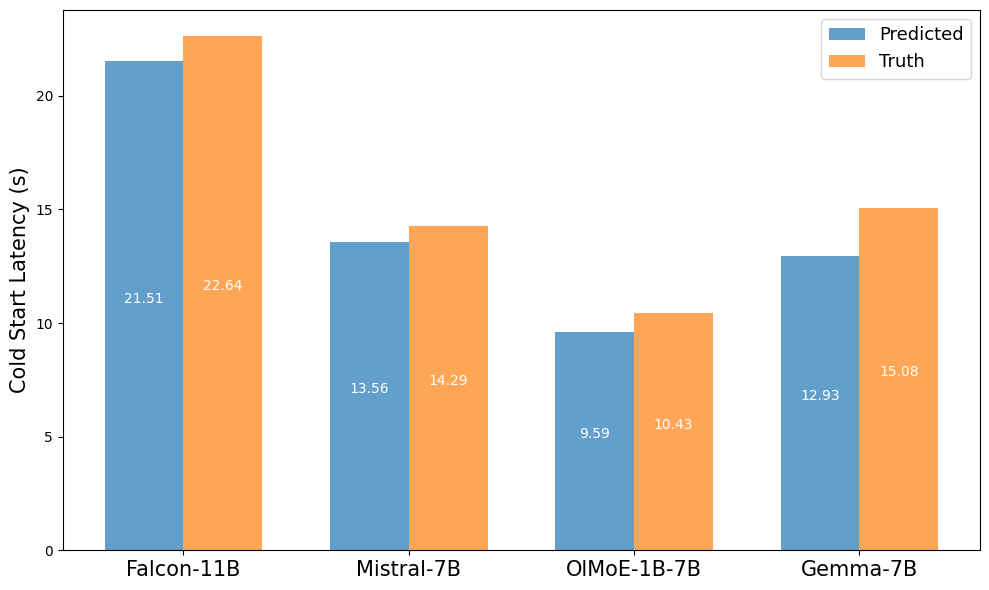

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from predictor.run_predictor import predict

model_names_map = {
    "falcon-11b": "Falcon-11B",
    "mistral-7b": "Mistral-7B",
    "olmoe-7b": "OlMoE-1B-7B",
    "gemma-7b": "Gemma-7B"
}

results = predict("predictor_info/models", "predictor_info/test_data.json")["validation"]

print(results)
# Data
models = []
predicted = []
truth = []
diff = []
for x in results:
    label = x["label"]
    if label in model_names_map:
        models.append(model_names_map[label])
        predicted.append(x["predicted"])
        truth.append(x["truth"])
        diff.append(x["diff"])
    
x = np.arange(len(models))
width = 0.35  # bar width

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bars: Predicted vs Truth
bars1 = ax1.bar(x - width/2, predicted, width, label="Predicted", alpha=0.7)
bars2 = ax1.bar(x + width/2, truth, width, label="Truth", alpha=0.7)

for bar in bars1 + bars2:
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=10, color='white')

ax1.set_ylabel("Cold Start Latency (s)", fontsize=15)
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=15)
ax1.legend(fontsize=13)

plt.tight_layout()
plt.savefig(
    "figures/predictor-validation.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()


### Figure 10: Impact of Different GPU


Comparing actual_total_time
Avg Speedup: 1.00x

Comparing model_init
Avg Speedup: 0.94x

Comparing dynamo_transform_time
Avg Speedup: 1.00x

Comparing graph_compile_cached
Avg Speedup: 0.98x

Comparing graph_capturing
Avg Speedup: 1.20x

Comparing kv_cache_profiling
Avg Speedup: 0.97x

Comparing tokenizer_init
Avg Speedup: 0.98x

Comparing total_time
Avg Speedup: 1.00x


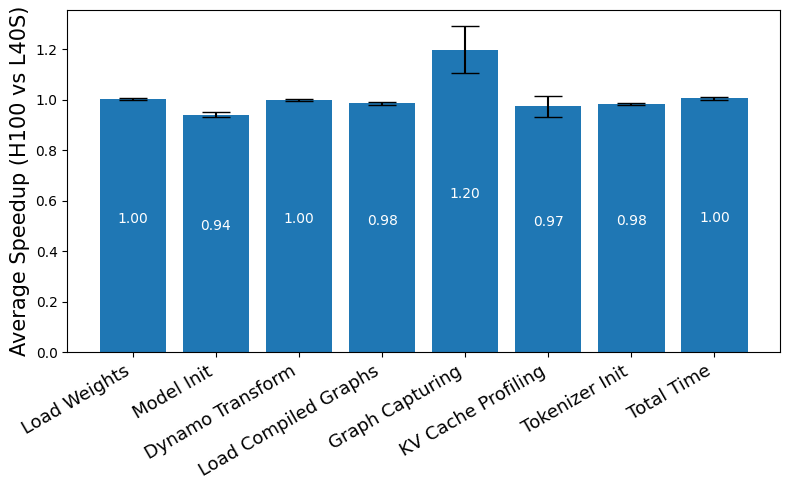

In [53]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from compare_2_avgs import compare_files

steps_map = {
    "load_weights": "Load Weights",
    "model_init": "Model Init",
    "dynamo_transform_time": "Dynamo Transform",
    "graph_compile_cached": "Load Compiled Graphs",
    "graph_capturing": "Graph Capturing",
    "kv_cache_profiling": "KV Cache Profiling",
    "tokenizer_init": "Tokenizer Init",
    "total_time": "Total Time"
}

h100_filepath = "examples/model_size/avg_comparison_results.json"
l40s_filepath = "../node5/examples/model_size/avg_comparison_results.json"
output_results = compare_files(h100_filepath, l40s_filepath)


steps = list(output_results.keys())
avg_speedups = []
stderr_speedups = []

for step in steps:
    speedups = [entry["speedup"] for entry in output_results[step]]
    avg_speedups.append(np.mean(speedups))
    stderr_speedups.append(stats.sem(speedups))

x = np.arange(len(steps))
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(x, avg_speedups, yerr=stderr_speedups, capsize=10, ecolor='black')

ax.set_xticks(x)
ax.set_xticklabels([steps_map[s] for s in steps], rotation=30, ha='right', fontsize=13)
ax.set_ylabel("Average Speedup (H100 vs L40S)", fontsize=15)

# Annotate each bar with its value
for bar, value in zip(bars, avg_speedups):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{value:.2f}", ha='center', va='bottom', fontsize=10, color='white')

plt.tight_layout()
plt.savefig(
    "figures/h100-vs-l40s.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

### Tokenizer size vs vocab size

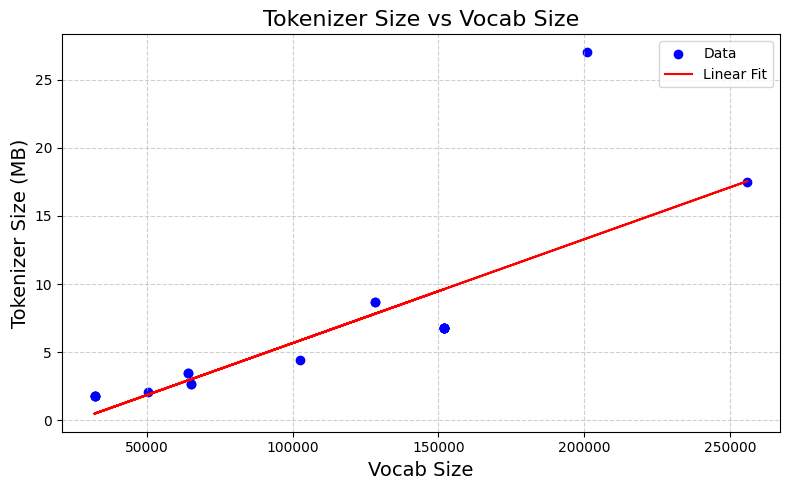

In [54]:
import json 
import matplotlib.pyplot as plt

model_configs = {}
with open("../../../vllm-profiling/models_config.json", "r") as f:
    model_configs = json.load(f)
    
tokenizer_sizes = [values["tokenizer_size"] for _,values in model_configs.items()]
vocab_sizes = [values["vocab_size"] for _,values in model_configs.items()]
model_names = [key for key, _ in model_configs.items()]

plt.figure(figsize=(8, 5))
plt.scatter(vocab_sizes, tokenizer_sizes, color='blue', label='Data')

# Fit linear regression
X = np.array(vocab_sizes).reshape(-1, 1)
y = np.array(tokenizer_sizes)
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

plt.plot(vocab_sizes, y_pred, color='red', label='Linear Fit')
plt.xlabel("Vocab Size", fontsize=14)
plt.ylabel("Tokenizer Size (MB)", fontsize=14)
plt.title("Tokenizer Size vs Vocab Size", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
# Annotate each point with its model name
# for i, name in enumerate(model_names):
#     plt.annotate(name, (vocab_sizes[i], tokenizer_sizes[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
plt.tight_layout()
plt.show()